# CIS-522 Week 5 Homework


**Instructor:** Lyle Ungar

**Content Creators:** Jordan Lei


In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'jabrantl' #@param {type:"string"}
my_pod = 'superfluous-lyrebird' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion','astute-jellyfish', 'quantum-herring']

# start timing
import time
try:t0;
except NameError: t0 = time.time()


In [2]:
#@markdown Run this cell for imports. It should print "cuda"
#@markdown 
from __future__ import print_function
import torch
import pathlib
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import time
import numpy as np
import matplotlib.pyplot as plt
import copy

torch.manual_seed(2021)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Part 1. Attack!
In this homework, you will implement a simple adversarial attack on a neural network trained on MNIST handwritten digits. It might sound complicated, but we'll guide you through it step by step. First, let's download and familiarize ourselves with the dataset. 

**Run the cell below. Do not modify.**


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



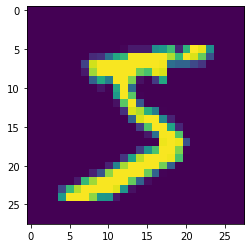

Above, I have an image with the corresponding label: 5


In [3]:
dataset = datasets.MNIST("/content/", download = True, train = True, transform = transforms.ToTensor())

len_train = int(0.8 * len(dataset))
len_val = len(dataset) - len_train
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [len_train, len_val])

#train_loader is the data loader containing the training samples
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
#val_loader is the data loader containing the validation samples
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

#visualize one of the elements
base_image = dataset[0][0].reshape(1, 784)
plt.imshow(base_image.reshape(28, 28).numpy())
plt.show()
print("Above, I have an image with the corresponding label:", dataset[0][1])

## 1.1 Network
MNIST digits come in images of size 28 x 28, and have an output of size 10. Let's construct a simple feedforward network with a *single hidden layer of size 64*. That is, our network should be shape *input --> 64 --> output*, with ReLU activations after each layer.

**Your turn. Fill in the missing parts of the network definition**

In [ ]:
class Net1(nn.Module): 
  def __init__(self):
    super(Net1, self).__init__()
    self.l1 = nn.Linear(28*28,64) #TODO: add the first linear module from input size to hidden size
    self.l2 = nn.Linear(64,10)#TODO: add the second linear module from hidden size to output size
  
  def forward(self, x): 
    x = self.l1(x) #TODO: pass x through the first linear module, then through relu
    x = F.relu(x)
    x = self.l2(x) #TODO: pass x through the second linear module, then through relu
    x = F.relu(x)
    return x

## 1.2 Define Functions
Now we want to define `train` and `test` functions to train and test our network, respectively. Fill in the "TODO" sections below for the train and test functions. 

**Your turn. Fill in the missing parts of the `train` and `test` functions**


In [ ]:
def train(train_loader, net, optimizer, criterion, epochs = 10):
  for epoch in range(epochs): 
    c = 0
    total_loss = 0
    total_correct = 0
    for i, (image, label) in enumerate(train_loader):
      #As a safety precaution, we zero out the gradients in the beginning
      optimizer.zero_grad()

      #MNIST images are [batch_size, 1, 28, 28] by default, so we need to
      #reshape them to [batch_size, 784] for our network. We also need
      #to send our images and labels to our GPU
      image = image.view(-1, 784).to(device)
      label = label.to(device)

      #use your network to make a prediction
      prediction = net(image) #TODO: define prediction

      #calculate the loss using the criterion, prediction, and label
      loss = criterion(prediction,label) #TODO: calculate the loss
      
      #make the backward pass on your loss
      loss.backward() #TODO: backward pass

      #make a step with your optimizer
      optimizer.step() #TODO step with your optimizer

      predicted_class = torch.argmax(prediction, 1)
      correct = torch.sum((predicted_class == label))

      total_loss += loss
      total_correct += correct
      c += len(label)

      if i%500 == 0:
        print("[Epoch %s]\tAcc:%.4f\tLoss:%.4f"%(epoch, (total_correct/c).item(), (total_loss/c).item()))


def test(test_loader, net, criterion): 
  c = 0
  total_loss = 0
  total_correct = 0
  for i, (image, label) in enumerate(test_loader): 
    image = image.view(-1, 784).to(device)
    label = label.to(device)
    #use your network to make a prediction
    prediction = net(image) #TODO: define prediction (feel free to copy+paste from above)

    #calculate the loss using the criterion, prediction, and label
    loss = criterion(prediction,label) #TODO define loss (feel free to copy+paste from above)

    predicted_class = torch.argmax(prediction, 1)
    total_loss += loss.item()
    total_correct += torch.sum((predicted_class == label)).item()
    c += len(label)

  return total_loss/c, total_correct/c

## 1.3 Train the Network
Now let's train the network. Define the following: 
* `net`: initialize the network with the `Net1` class. Make sure you send the network to cuda!
* `optimizer`: use an Adam optimizer with learning rate 0.01, and initialize it with your network parameters.
* `criterion`: choose a good criterion for this task. Consider looking at: https://pytorch.org/docs/stable/nn.html#loss-function. 

**Your turn. Define the net, optimizer, and criterion.**

In [ ]:
net = Net1().to(device) #TODO: define net, send it to device
optimizer = torch.optim.Adam(net.parameters(),lr=0.01) #TODO: define optimizer
criterion = nn.CrossEntropyLoss() #TODO: choose a good criterion

train(train_loader, net, optimizer, criterion)
loss, accuracy = test(val_loader, net, criterion)
print("Evaluation\n\tTest Loss: %.4f\tTest Accuracy: %.2f%%"%(loss, accuracy*100))

[Epoch 0]	Acc:0.0938	Loss:0.0361
[Epoch 0]	Acc:0.5710	Loss:0.0175
[Epoch 1]	Acc:0.6094	Loss:0.0148
[Epoch 1]	Acc:0.6650	Loss:0.0133
[Epoch 2]	Acc:0.6875	Loss:0.0120
[Epoch 2]	Acc:0.6728	Loss:0.0126
[Epoch 3]	Acc:0.7500	Loss:0.0093
[Epoch 3]	Acc:0.6758	Loss:0.0124
[Epoch 4]	Acc:0.6562	Loss:0.0132
[Epoch 4]	Acc:0.6758	Loss:0.0124
[Epoch 5]	Acc:0.6875	Loss:0.0121
[Epoch 5]	Acc:0.6793	Loss:0.0121
[Epoch 6]	Acc:0.5938	Loss:0.0147
[Epoch 6]	Acc:0.6797	Loss:0.0121
[Epoch 7]	Acc:0.6406	Loss:0.0133
[Epoch 7]	Acc:0.6781	Loss:0.0122
[Epoch 8]	Acc:0.7188	Loss:0.0101
[Epoch 8]	Acc:0.6803	Loss:0.0120
[Epoch 9]	Acc:0.7188	Loss:0.0113
[Epoch 9]	Acc:0.6817	Loss:0.0119
Evaluation
	Test Loss: 0.0135	Test Accuracy: 66.66%


## 1.4 How Did We Do? 
Confirm that your test loss above is exactly `0.0027` and your Test Accuracy is exactly `96.53%`. Don't move on until you confirm this is the case; if you get stuck, feel free to phone a friend or your friendly neighborhood pod leader.

Now let's see how our network performs on the image we showed above! Run the cell below. 
**Run the cell below. Do not modify**

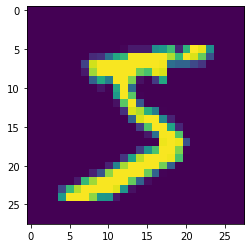

My Network Predicts That This Number Is... 5


In [ ]:
base_image = dataset[0][0].reshape(1, 784)
plt.imshow(base_image.reshape(28, 28).numpy())
plt.show()
net_prediction = torch.argmax(net(base_image.to(device))).item()
print("My Network Predicts That This Number Is... %s"%(net_prediction))

## 1.5 Adversarial Attack
Now for the fun part. Let's attack our network by creating an image that looks almost exactly like the one above, but makes it mistake the digit for a 3! How do we do that? 

Here's one way of doing it: instead of updating the **weights of our network**, what if we updated the **pixels of our image** using gradient descent? Take a moment to read that again. We're going to require gradients on our **image**, and then update it until the network is properly fooled!

Our problem is complex though. We have two goals: 


1.   `criterion_1`: We want to fool the network into thinking that the image is a 3, not a 5. 
2.   `criterion_2`: We want to make sure the modified image `mod_image` looks as much like the original `base_image` as possible.

Our loss will be a weighted sum between the losses evaluated on these two criteria, i.e. `loss = weight_1 * loss_1 + weight_2 * loss_2`. For our code below, let `weight_1 = 0.001` and `weight_2 = 1`.

**Your turn. Define `criterion_1`, `criterion_2`, `loss_1`, `loss_2`, and `loss`. Run the code; if your attack is successful it will print "ATTACK SUCCESSFUL"**




In [ ]:
#create a copy of base_image which we can modify
mod_image = base_image.clone() 
#our target class is 3. We send this to the device
target = torch.LongTensor([3]).to(device)
optimizer = optim.SGD([mod_image.requires_grad_(True)], lr = 0.01)

#Choose a good criterion to compare our prediction with the target
#hint: these are categorical variables
criterion1 = nn.CrossEntropyLoss() #TODO: choose criterion1
weight_1   = 0.001
#Choose a good criterion which describes how "far off" our mod_image
#differs from base_image
#hint: think about how we might measure the "distance" between two images
criterion2 = nn.MSELoss() #TODO: choose criterion2
weight_2   = 1

for i in range(10000):
  prediction = net(mod_image.to(device))

  #loss_1 is the result of evaluating criterion_1 on the prediction of the net
  #compared to the target class.
  loss_1 = criterion1(prediction,target) #TODO: define loss_1

  #loss_2 is the result of evaluating criterion_2 on the current image
  #(mod_image) compared to the original image (base_image).
  loss_2 = criterion2(base_image,mod_image) #TODO: define loss_2

  #the final loss is a weighted sum of the losses, where weight_1 = 0.001 and weight_2 = 1
  loss = weight_1*loss_1 + weight_2*loss_2 #TODO: define loss
  loss.backward()
  optimizer.step()

  predicted_class = torch.argmax(prediction)

  if predicted_class == target:
    print("Predicted Class: %s, Loss: %s, ATTACK SUCCESSFUL!"%(predicted_class.item(), loss.item()))
    break
  else:
    if i%10 == 0: 
      print("Predicted Class: %s, Loss: %s"%(predicted_class.item(), loss.item()))

Predicted Class: 5, Loss: 0.003953384701162577
Predicted Class: 5, Loss: 0.0039306082762777805
Predicted Class: 5, Loss: 0.003866732819005847
Predicted Class: 5, Loss: 0.0037626309785991907
Predicted Class: 5, Loss: 0.0036197917070239782
Predicted Class: 5, Loss: 0.0034403589088469744
Predicted Class: 5, Loss: 0.0032272599637508392
Predicted Class: 5, Loss: 0.0029843805823475122
Predicted Class: 5, Loss: 0.0027168728411197662
Predicted Class: 5, Loss: 0.002431617584079504
Predicted Class: 5, Loss: 0.002114694332703948
Predicted Class: 5, Loss: 0.0017761283088475466
Predicted Class: 5, Loss: 0.001462208922021091
Predicted Class: 5, Loss: 0.0012127221561968327
Predicted Class: 3, Loss: 0.0010935231111943722, ATTACK SUCCESSFUL!


So what does our image look like now? Run the cell below to compare the original input to the modified image, and how our network classifies each. Did we succeed?

**Take a screenshot of the output of this cell and save it for later.**

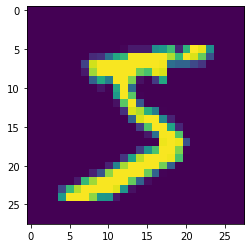

My Network Predicts That This Number Is... 5


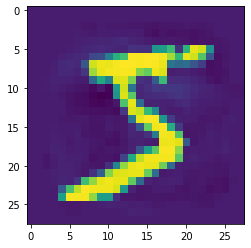

My Network Predicts That This Number Is... 3


In [ ]:
#@markdown Run this cell to display your adversarial attack!
net.eval()
plt.imshow(base_image.reshape(28, 28).detach().numpy())
plt.show()
net_prediction = torch.argmax(net(base_image.to(device))).item()
print("My Network Predicts That This Number Is... %s"%(net_prediction))
plt.imshow(mod_image.reshape(28, 28).detach().numpy())
plt.show()
net_prediction = torch.argmax(net(mod_image.to(device))).item()
print("My Network Predicts That This Number Is... %s"%(net_prediction))

# Part 2. Defend!
In this next part of the homework, we will ask you to use **regularization** to defend against the adversarial image you constructed in part 1. Try each of the following regularization techniques: 
* Early stopping
* Dropout (https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
* L2 regularization (hint: see the `weight_decay` parameter in optim.Adam: https://pytorch.org/docs/stable/optim.html)



## 2.1 Train your Defense
In this section, you'll train a network which will be able to detect that the adversarial image is a 5, not a 3. Feel free to copy + paste code from the above sections as needed. 
**Make sure your network is exactly the same architecture as you had (with the exception of adding dropout layers)!**

**Your turn. Train your network on each regularization technique below. We recommend that you try each technique individually, and then combine them if necessary. Once your net completes training, you may test it on the adversarial image in the following section.**

In [ ]:
#Net2 should be the same architecture as Net1 with the exception of dropout layers
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.l1      = nn.Linear(28*28,64) #TODO: add the first linear module from input size to hidden size
    self.l2      = nn.Linear(64,10)#TODO: add the second linear module from hidden size to output size
    self.dropout = nn.Dropout(0.5)

  def forward(self, x): 
    x = self.l1(x) #TODO: pass x through the first linear module, then through relu
    x = F.relu(x)
    x = self.dropout(x)
    x = self.l2(x) #TODO: pass x through the second linear module, then through relu
    x = F.relu(x)
    return x

In [ ]:
net = Net2().to(device) #TODO: define net
optimizer = torch.optim.Adam(net.parameters(),lr=0.01,weight_decay=0.001) #TODO: define optimizer
criterion = nn.CrossEntropyLoss() #TODO: choose a good criterion

train(train_loader, net, optimizer, criterion)
loss, accuracy = test(val_loader, net, criterion)
print("Evaluation\n\tTest Loss: %.4f\tTest Accuracy: %.2f%%"%(loss, accuracy*100))

[Epoch 0]	Acc:0.0938	Loss:0.0361
[Epoch 0]	Acc:0.6835	Loss:0.0150
[Epoch 1]	Acc:0.7656	Loss:0.0123
[Epoch 1]	Acc:0.7958	Loss:0.0101
[Epoch 2]	Acc:0.7812	Loss:0.0097
[Epoch 2]	Acc:0.8440	Loss:0.0079
[Epoch 3]	Acc:0.8125	Loss:0.0080
[Epoch 3]	Acc:0.8445	Loss:0.0078
[Epoch 4]	Acc:0.8750	Loss:0.0076
[Epoch 4]	Acc:0.8467	Loss:0.0078
[Epoch 5]	Acc:0.8594	Loss:0.0061
[Epoch 5]	Acc:0.8470	Loss:0.0077
[Epoch 6]	Acc:0.8750	Loss:0.0071
[Epoch 6]	Acc:0.8499	Loss:0.0077
[Epoch 7]	Acc:0.7812	Loss:0.0102
[Epoch 7]	Acc:0.8465	Loss:0.0077
[Epoch 8]	Acc:0.8594	Loss:0.0053
[Epoch 8]	Acc:0.8523	Loss:0.0076
[Epoch 9]	Acc:0.8125	Loss:0.0097
[Epoch 9]	Acc:0.8495	Loss:0.0077
Evaluation
	Test Loss: 0.0078	Test Accuracy: 84.74%


## 2.2 How Did We Do?
Run the code below to test if your regularization worked. If successful, it will print "DEFENSE SUCCESSFUL". 

**Run the code below. Do not modify. If successful, take a screenshot and write down what regularization parameters led to your success**

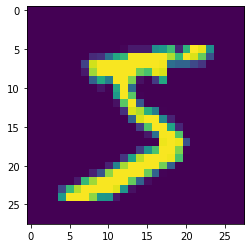

My Regularized Network Predicts That This Number Is... 5


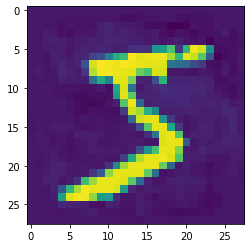

My Regularized Network Predicts That This Number Is... 5
DEFENSE SUCCESSFUL!


In [ ]:
#@markdown Run this cell to test your defense!
net.eval()

plt.imshow(base_image.reshape(28, 28).detach().numpy())
plt.show()
prediction_orig = net(mod_image.to(device))
net_predicted_class_orig = torch.argmax(prediction_orig).item()
print("My Regularized Network Predicts That This Number Is... %s"%(net_predicted_class_orig))
plt.imshow(mod_image.reshape(28, 28).detach().numpy())
plt.show()

prediction = net(mod_image.to(device))
net_predicted_class = torch.argmax(prediction).item()
print("My Regularized Network Predicts That This Number Is... %s"%(net_predicted_class))
if net_predicted_class_orig == 5 and net_predicted_class == 5: 
  print("DEFENSE SUCCESSFUL!")
  saved_prediction = prediction
else: 
  print("AW, SNAP! FOOLED AGAIN! GO BACK AND TRY A DIFFERENT REGULARIZATION COMBO")

**Write answers to the following questions below**
1. How did your regularized models compare to your original model, in terms of overall accuracy? How did they compare to one another?
2. Did your regularized models successfully defend against the adversarial task? If so, what parameters contributed to your success? 
3. You might have noticed that your adversarial image successfully fooled your network under a lot of different regularization conditions. You can verify this yourself, but it turns out that this adversarial image is capable of fooling networks with different architectures, and even possibly other learning models (decision trees, K-means, etc.) trained on MNIST. *In short, attacking one network can create an effective attack on a wide variety of learning algorithms.* Given this information, describe what implications this has for machine learning for security, and why it is hard to defend against these attacks.

In [ ]:
#Remove starter text and write your answer.
q_2_2 = '''
1&2. The model that was used to achieve a successful defense included a dropout(0.5) layer between ReLu(layer1) and layer2 and the addition of weight_decay<0.01 in Adam. These did not work individually but worked well together. Interestingly, the the model performance was always in the mid 80's%. The models I trained that achieved >90% performance were not successful against the defense.
3. This is a concern for many security issues, such as facial recognition, object recognition for self-driving vehicles, etc. One could easily create a situation in which an AI-enabled system makes harmful decisions due to these adversarial attacks. The challenge of defending against these attacks is that the problem of knowing which attacks to defend against is ill-posed. There are innumerable attacks that can be generated yet each defense depends on having seen the exact or similar attack. 
'''

# Part 3. Deep Learning, Deeper Thinking


Now that you've gotten familiar with adversarial attacks and regularization, it's time to think about some of the implications of these attacks. First, read the following:

* https://openai.com/blog/adversarial-example-research/
* https://www.sciencedirect.com/science/article/pii/S0743731518309183
(accessible through Penn Libraries)



## Part 3.1 Reflect
**Short answer: what type of adversarial attack did we conduct in section 1.5 (choose the most similar one based on the descriptions in the second paper)?**


In [ ]:
q_3_1 = '''
Attack during testing phase - seems similar to the Fast gradient sign method since we are applying perturbations to the image in the direction of the image gradient. 

'''

## Part 3.1 Discuss
**In 200-300 words, please answer the following questions, and also post these to Slack**
* As engineers, how can we safeguard against adversarial attacks? Give a real-world example of what an adversarial attack might look like (aside from the one you just deployed), and what consequences it might have.
* How might adversarial attacks on machine learning algorithms impact public trust of these algorithms? How might we communicate these risks to the public? 
* In your own words, why doesn't "gradient masking" work?


In [ ]:
q_3_2 = '''
1. One of the first ways is to secure our networks to minimize their ability to be reverse-engineered. Another potential way is to perturb our input data in a way that will not degrade model performance but will render the attack useless since it does not possess the same invariance properties. 
2. Some examples of adverserial attacks that might impact public trust are accidents by self-driving cars or incorrect medical results, such as missed diagnosis or improper treatment. These would certainly degrade trust of these algorithms. I don't know exactly how the best approach for conveying this to the public is, but it seems that a comparison to hacking or spamming could be easily drawn. Most people are familiar with the concpets of online bots or spam calls at attempt to deceive us. For example, the voices used by robo-calls have become more sophisticated, with spammers going as far as to introduced coughs, voice irregularites, or expressions like, "can you hear me?". 
3. Gradient masking seeks to smooth the gradient so the adversary cannot find a gradient direction that adequately perturbs the input. However, a surrogate model can be trained that does not have the same smooth gradient. As a result, the second model can generate perturbed data that will attack the original model since these adverserial perturbations can be transfered. 
'''

# Part 4. Rethinking Generalization


Read the first three pages of this article on "Understanding Deep Learning Requires Rethinking Generalization" [https://arxiv.org/pdf/1611.03530.pdf] and Answer the following questions:

1. Why is it important that neural nets can learn to get zero training error on 
images with randomized labels, or even with images that are pure random noise?

In [ ]:
q_4_1 = """
This is important because it tells us that neural networks are capable of identifying even a small amount of signal when the noise is high, and that they are able to fit the noise well. This also tells us that the number of parameters in the model is sufficient to allow memorization of the complete dataset. 
"""

2. How many weights are needed in a 2-layer ReLU to fit n observations each of dimension d?


In [ ]:
q_4_2 = """
For samples, n, with dimensions, d, the model requires p = 2n+d parameters.
"""

3. Are standard regularization methods (e.g. L1, L2, early stopping) required to prevent overfitting?

In [ ]:
q_4_3 = """
They may help but they are not required.
"""

4. The authors argue that “implicit regularization” is more important than explicit regularization. What do they mean by “implicit regularization” and how does it work?

In [ ]:
q_4_4 = """
Implicit regularization occurs when some part of the training leads to model regularization and norm shrinkage w/o explicit regularization penalties. Examples are early stopping and stochastic gradient descent, which drive the model towards a small norm. 
"""

# Part 5. Better-Know-A-Pod


*This section is designed to let you better know your pod mates. You are encouraged to discuss these with your pod mates during pod sessions or during pod social events, but NOT over Slack. The idea is to get to know your pod mates face-to-face.*

**List 2 other members of your pod - not the same two that you listed last homework. What are they most excited about doing after the pandemic is over, and why? (around 100 words each).**





In [ ]:
better_know_a_pod = '''
Felipe Parodi: I chatted with Felipe, who is a PhD student in the Platt and Kording labs. He is looking forward to a normal schedule where he can go into lab and actually interact with people. 
He is excited to return to Penn Park to play pick-up soccer, especially over the summer. He is excited to get to know Philly. He moved here last semester but does not really know much about the city. 
I agree with the sentiment in all his points. I have two kids so being in the lab is the only way to ensure the opportunity for productivity. I love rock climbing, so I feel the same way about going to the climbing gym (although I have been able to spend time outside!). I moved to Philly two weeks before everything shut down and so I also have limited experience with the city. 
'''

# Submission
**Load the airtable below. Remember to attach the screenshots you took from section 1.5 and section 2.2!**

In [ ]:
#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**
import time
import numpy as np
import urllib.parse
from IPython.display import IFrame
def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: q_2_2;
except NameError: q_2_2 = ""
try: q_3_1;
except NameError: q_3_1 = ""
try: q_3_2;
except NameError: q_3_2 = ""
try: q_4_1;
except NameError: q_4_1 = ""
try: q_4_2;
except NameError: q_4_2 = ""
try: q_4_3;
except NameError: q_4_3 = ""
try: q_4_4;
except NameError: q_4_4 = ""

#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
times = np.array([t1])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "q_2_2":q_2_2,
          "q_3_1":q_3_1,
          "q_3_2":q_3_2,
          "q_4_1":q_4_1,
          "q_4_2":q_4_2,
          "q_4_3":q_4_3,
          "q_4_4":q_4_4,
          "better_know_a_pod":better_know_a_pod,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrgO2VsoOSFLqCNz?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))